# Memory-Efficient Binary Neural Network (BNN) for Plant Disease Classification - 64x64 Images

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification, optimized for handling 64x64 images on GPUs with limited memory.

## Memory Management Guide

This notebook has been optimized for running on GPUs with limited memory (under 4GB). The settings have been automatically adjusted to "aggressive" mode to prevent CUDA out-of-memory errors.

### Current Memory-Optimized Settings:
- Image resolution: 64x64 (lowest resolution version)
- Batch size: 8 (optimized for 64x64 images)
- Hidden size: 256 (compact model architecture)
- Progressive dimensionality reduction (multiple embedding steps)
- Gradient accumulation: 8 steps (effective batch size of 64)
- Mixed precision training (FP16)

### Memory Monitoring
You can monitor GPU memory usage by checking the output of the memory monitoring tools included at the beginning of the notebook.

# Binary Neural Network (BNN) for Plant Disease Classification

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification. The BNN uses binary weights and activations to reduce model size and computational requirements while maintaining reasonable accuracy.

## Features:
- Binary weights and activations using sign function
- Processes 64x64 RGB images (memory-optimized)
- Progressive dimensionality reduction for memory efficiency
- Binary hidden layers with binary weights
- Batch normalization for improved stability
- Dropout for regularization
- Learning rate scheduling for better convergence
- Multiclass output with softmax activation
- Mixed precision training
- Gradient accumulation

In [1]:
# Import Required Libraries
# %pip install torch torchvision matplotlib numpy pandas seaborn scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import os

# Set environment variable for better CUDA error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check if CUDA is available and print version info
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device count: {torch.cuda.device_count()}")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("CUDA not available, using CPU")
    device = torch.device('cpu')

# Set random seeds safely
random.seed(42)
np.random.seed(42)
try:
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
except RuntimeError as e:
    print(f"Error setting CUDA seed: {e}")
    print("Falling back to CPU")
    device = torch.device('cpu')

print(f"Using device: {device}")

CUDA available: True
CUDA version: 12.6
GPU device count: 1
GPU device name: NVIDIA GeForce GTX 1650
Using device: cuda


In [2]:
# Additional imports for enhanced visualization and data export
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import time
import datetime
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create results directory
os.makedirs('results', exist_ok=True)
print("Results directory created: ./results/")

Results directory created: ./results/


In [3]:
# Memory Monitoring and Optimization Utilities
import gc
import psutil

def print_gpu_memory_stats():
    """Print detailed GPU memory statistics"""
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        allocated = torch.cuda.memory_allocated() / (1024 ** 3)
        reserved = torch.cuda.memory_reserved() / (1024 ** 3)
        max_allocated = torch.cuda.max_memory_allocated() / (1024 ** 3)
        
        print(f"Memory allocated: {allocated:.2f} GB")
        print(f"Memory reserved: {reserved:.2f} GB")
        print(f"Max memory allocated: {max_allocated:.2f} GB")
        
        if hasattr(torch.cuda, 'memory_summary'):
            print("\nMemory Summary:")
            print(torch.cuda.memory_summary(abbreviated=True))
    else:
        print("CUDA not available")

def print_system_memory():
    """Print system memory usage"""
    vm = psutil.virtual_memory()
    print(f"System memory: {vm.total / (1024**3):.1f} GB total, " 
          f"{vm.available / (1024**3):.1f} GB available, "
          f"{vm.percent}% used")

# def optimize_memory(mode='aggressive'):
def optimize_memory(mode='moderate'):
    """Apply memory optimization settings based on selected mode"""
    if mode == 'aggressive':
        # Most aggressive memory saving settings
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:32'
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        return {
            'image_size': 64,  # Reduced image size for less memory usage
            'batch_size': 16,  # Slightly larger batch size for 64x64 images
            'hidden_size': 256,
            'embedding_size': 512,
            'num_hidden_layers': 1,
            'gradient_accumulation': 8,
            'max_samples_per_class': None  # No sample limiting for 64x64
        }
    elif mode == 'moderate':
        # Balanced memory saving
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:64'
        torch.backends.cudnn.benchmark = True
        return {
            'image_size': 64,  # Using 64x64 for this notebook
            'batch_size': 8,
            'hidden_size': 320,
            'embedding_size': 640,
            'num_hidden_layers': 1,
            # 'num_hidden_layers': 2,
            'gradient_accumulation': 4,
            'max_samples_per_class': None
        }
    else:  # 'performance' mode
        # Optimized for performance, higher memory usage
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
        torch.backends.cudnn.benchmark = True
        return {
            'image_size': 64,  # Using 64x64 for this notebook
            'batch_size': 64,
            'hidden_size': 512,
            'embedding_size': 1024,
            'num_hidden_layers': 2,
            'gradient_accumulation': 2,
            'max_samples_per_class': None
        }

# Check current memory status
print("Initial memory status:")
print_system_memory()
print_gpu_memory_stats()

# Memory optimization mode - set this to 'performance', 'moderate', or 'aggressive'
# memory_mode = 'aggressive'  # Using aggressive mode to avoid CUDA OOM errors
# memory_mode = 'moderate'  # Using aggressive mode to avoid CUDA OOM errors
memory_mode = 'aggressive'  # Using aggressive mode to avoid CUDA OOM errors
print(f"\nUsing {memory_mode} memory optimization settings")
memory_config = optimize_memory(memory_mode)
print(f"Recommended settings: {memory_config}")

# Create results directory
os.makedirs('results', exist_ok=True)
print("\nResults directory created: ./results/")

Initial memory status:
System memory: 15.0 GB total, 8.6 GB available, 42.5% used
GPU: NVIDIA GeForce GTX 1650
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
Max memory allocated: 0.00 GB

Memory Summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|----------

In [4]:
# Binary Activation Function
class BinaryActivation(torch.autograd.Function):
    """
    Binary activation function using the sign function.
    Forward: sign(x) = {-1 if x < 0, +1 if x >= 0}
    Backward: Straight-through estimator (STE) - passes gradients through unchanged
    """
    
    @staticmethod
    def forward(ctx, input):
        # Apply sign function: -1 for negative, +1 for non-negative
        return torch.sign(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients through unchanged
        # This allows gradients to flow back during training
        return grad_output

def binary_activation(x):
    """Wrapper function for binary activation"""
    return BinaryActivation.apply(x)

In [5]:
# Binary Linear Layer
class BinaryLinear(nn.Module):
    """
    Binary Linear layer with binary weights.
    Weights are binarized using the sign function during forward pass.
    """
    
    def __init__(self, in_features, out_features, bias=True):
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using normal distribution
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, input):
        # Binarize weights using sign function
        binary_weight = torch.sign(self.weight)
        
        # Perform linear transformation with binary weights
        output = F.linear(input, binary_weight, self.bias)
        
        return output
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [6]:
# Binary Neural Network Model
class BinaryNeuralNetwork(nn.Module):
    """
    Memory-efficient Binary Neural Network for multiclass plant disease classification.
    
    Architecture:
    - Input: Flattened RGB images (3*image_size*image_size features)
    - Progressive dimensionality reduction: Multiple steps to reduce memory usage
    - Feature embedding: Further reduces dimensionality for memory efficiency 
    - Binary Hidden Layers: Binary linear layers with binary activation
    - Output Layer: Regular linear layer for class logits
    - Final: Softmax for multiclass prediction
    """
    
    def __init__(self, input_size=3*64*64, hidden_size=256, num_classes=3, 
                 num_hidden_layers=2, embedding_size=512, dropout_rate=0.2):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_hidden_layers = num_hidden_layers
        self.embedding_size = embedding_size
        
        # Calculate intermediate sizes for progressive dimension reduction
        # For 64x64 images, we can use fewer reduction steps
        intermediate_size1 = min(input_size // 4, 4096)  # First reduction
        intermediate_size2 = min(intermediate_size1 // 2, 2048)  # Second reduction
        intermediate_size3 = min(intermediate_size2 // 2, 1024)  # Final intermediate step before embedding
        
        print(f"Progressive dimension reduction: {input_size} → {intermediate_size1} → {intermediate_size2} → {intermediate_size3} → {embedding_size}")
        
        # Initial dimensionality reduction for memory efficiency - progressive steps
        self.embedding = nn.Sequential(
            # First reduction
            nn.Linear(input_size, intermediate_size1),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_size1),
            nn.Dropout(dropout_rate),
            
            # Second reduction
            nn.Linear(intermediate_size1, intermediate_size2),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_size2),
            nn.Dropout(dropout_rate),
            
            # Third reduction
            nn.Linear(intermediate_size2, intermediate_size3),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_size3),
            nn.Dropout(dropout_rate),
            
            # Final embedding
            nn.Linear(intermediate_size3, embedding_size),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_size),
        )
        
        # First binary layer after embedding
        self.input_binary = BinaryLinear(embedding_size, hidden_size)
        
        # Multiple hidden binary layers
        self.hidden_layers = nn.ModuleList([
            BinaryLinear(hidden_size, hidden_size) for _ in range(num_hidden_layers)
        ])
        
        # Output layer: Regular linear layer for final classification
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Batch normalization for better training stability
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_hidden_layers + 1)  # +1 for input binary layer
        ])
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Flatten input if it's not already flattened
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, input_size)
        
        # Initial embedding to reduce dimensionality (memory efficient)
        x = self.embedding(x)
        
        # First binary layer
        x = self.input_binary(x)
        x = binary_activation(x)
        x = self.batch_norms[0](x)
        x = self.dropout(x)
        
        # Process through additional hidden binary layers
        for i in range(self.num_hidden_layers):
            x = self.hidden_layers[i](x)
            x = binary_activation(x)  # Binary activation function
            x = self.batch_norms[i+1](x)  # Apply batch normalization
            x = self.dropout(x)
        
        # Output layer (no activation - raw logits)
        logits = self.output_layer(x)
        
        return logits
    
    def predict_proba(self, x):
        """Get class probabilities using softmax"""
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities
    
    def predict(self, x):
        """Get predicted class labels"""
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

def evaluate_bnn_memory_efficient(model, test_loader, criterion, device, class_names, batch_limit=None, use_mixed_precision=False):
    """
    Memory-efficient evaluation function for BNN model
    
    Args:
        model: The trained BNN model
        test_loader: DataLoader for the test dataset
        criterion: Loss function
        device: Device to run evaluation on
        class_names: List of class names
        batch_limit: Limit the number of batches to evaluate (for debugging)
        use_mixed_precision: Whether to use mixed precision
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Import needed modules at the beginning of the function to avoid UnboundLocalError
    import torch
    import torch.nn.functional as F
    import time
    import contextlib
    
    model.eval()
    
    # Set up metrics
    test_loss = 0.0
    correct = 0
    total = 0
    
    # Initialize confusion matrix
    num_classes = len(class_names)
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    # Prepare for per-class metrics
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    # Set up for precision, recall, F1
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    
    # Store some sample images for visualization
    sample_images = []
    sample_labels = []
    sample_preds = []
    samples_collected = 0
    max_samples = 10  # Maximum number of samples to collect
    
    # For ROC curve
    all_targets = []
    all_probs = []
    
    # Check if mixed precision is available
    mixed_precision_available = use_mixed_precision and hasattr(torch, 'autocast')
    
    # Create an appropriate context manager for autocast based on PyTorch version
    if mixed_precision_available:
        try:
            # Get PyTorch version
            torch_version = torch.__version__
            major, minor = map(int, torch_version.split('.')[:2])
            
            # Different approaches based on PyTorch version
            if major > 1 or (major == 1 and minor >= 10):
                # PyTorch 1.10+ supports device_type parameter
                from torch.amp import autocast
                autocast_context = lambda: autocast(device_type=device.type)
            elif major == 1 and minor >= 6:
                # PyTorch 1.6-1.9 has autocast but without device_type parameter
                from torch.cuda.amp import autocast
                autocast_context = lambda: autocast()
            else:
                # Older versions - disable mixed precision
                mixed_precision_available = False
                autocast_context = contextlib.nullcontext
        except (ImportError, ValueError):
            # Fallback if there are issues
            mixed_precision_available = False
            autocast_context = contextlib.nullcontext
    else:
        autocast_context = contextlib.nullcontext

    # Track processing time
    start_time = time.time()
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Process batches
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Respect batch limit if specified
            if batch_limit is not None and batch_idx >= batch_limit:
                print(f"Evaluating model on {batch_limit} batches (limited)...")
                break
                
            if batch_idx == 0:
                print(f"Evaluating model on {len(test_loader)} batches (all)...")
                
            # Move data to device
            data, targets = data.to(device), targets.to(device)
            
            # Use mixed precision if available
            if mixed_precision_available:
                with autocast_context():
                    outputs = model(data)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
                
            # Accumulate loss
            test_loss += loss.item()
            
            # Get predictions
            _, predicted = outputs.max(1)
            
            # Update metrics
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store probabilities for ROC curve (using softmax)
            probs = F.softmax(outputs, dim=1)
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update confusion matrix
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                
            # Update per-class metrics
            for i in range(len(targets)):
                label = targets[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1
                    
            # Update precision, recall metrics
            for c in range(num_classes):
                true_positives[c] += ((predicted == c) & (targets == c)).sum().item()
                false_positives[c] += ((predicted == c) & (targets != c)).sum().item()
                false_negatives[c] += ((predicted != c) & (targets == c)).sum().item()
                
            # Collect sample images for visualization
            if samples_collected < max_samples:
                # Get a few samples from this batch
                num_to_collect = min(max_samples - samples_collected, data.size(0))
                sample_images.extend(data[:num_to_collect].cpu())
                sample_labels.extend(targets[:num_to_collect].cpu().numpy())
                sample_preds.extend(predicted[:num_to_collect].cpu().numpy())
                samples_collected += num_to_collect
                
            # Clean up memory
            del data, targets, outputs, predicted
            
    # Compute average loss
    test_loss /= len(test_loader)
    
    # Compute accuracy
    accuracy = 100. * correct / total
    
    # Compute per-class accuracy
    class_accuracy = [100. * class_correct[i] / max(1, class_total[i]) for i in range(num_classes)]
    
    # Compute precision, recall, F1
    precision = [true_positives[i] / max(1, true_positives[i] + false_positives[i]) for i in range(num_classes)]
    recall = [true_positives[i] / max(1, true_positives[i] + false_negatives[i]) for i in range(num_classes)]
    f1_score = [2 * precision[i] * recall[i] / max(1e-6, precision[i] + recall[i]) for i in range(num_classes)]
    
    # Calculate macro averages
    macro_precision = sum(precision) / num_classes
    macro_recall = sum(recall) / num_classes
    macro_f1 = sum(f1_score) / num_classes
    
    # Convert confusion matrix to percentage
    confusion_percentage = confusion_matrix.diag() / confusion_matrix.sum(1)
    
    # Track total processing time
    eval_time = time.time() - start_time
    
    # Return a comprehensive metrics dictionary
    metrics = {
        'loss': test_loss,
        'accuracy': accuracy,
        'class_accuracy': dict(zip(class_names, class_accuracy)),
        'precision': dict(zip(class_names, precision)),
        'recall': dict(zip(class_names, recall)),
        'f1_score': dict(zip(class_names, f1_score)),
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'confusion_matrix': confusion_matrix.cpu().numpy(),
        'confusion_percentage': confusion_percentage.cpu().numpy(),
        'class_distribution': dict(zip(class_names, class_total)),
        'evaluation_time': eval_time,
        'samples': {
            'images': sample_images,
            'true_labels': sample_labels,
            'predicted_labels': sample_preds,
        },
        'roc_data': {
            'targets': all_targets,
            'probs': all_probs,
        }
    }
    
    return metrics

In [7]:
# Enhanced Training and Evaluation Functions with Memory Optimization
def train_bnn_memory_efficient(model, train_loader, criterion, optimizer, device, 
                              num_epochs=10, scheduler=None, use_mixed_precision=False,
                              scaler=None, gradient_accumulation_steps=1, gc_frequency=10):
    """
    Memory-optimized training function with detailed metrics collection
    """
    model.train()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    epoch_times = []
    learning_rates = []
    
    # Detailed metrics per epoch
    training_history = []
    
    print(f"Starting memory-efficient training for {num_epochs} epochs...")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        batch_losses = []
        
        # Reset gradients at the beginning of each epoch
        optimizer.zero_grad()
        
        # Training loop
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Mixed precision training context
            if use_mixed_precision and scaler is not None:
                # Check PyTorch version for correct autocast usage
                torch_version = torch.__version__
                major, minor = map(int, torch_version.split('.')[:2])
                
                if major > 1 or (major == 1 and minor >= 10):
                    # PyTorch 1.10+ supports device_type parameter
                    with torch.amp.autocast(device_type=device.type):
                        outputs = model(data)
                        loss = criterion(outputs, targets)
                        # Scale loss for gradient accumulation
                        loss = loss / gradient_accumulation_steps
                elif major == 1 and minor >= 6:
                    # PyTorch 1.6-1.9 has autocast but without device_type parameter
                    with torch.cuda.amp.autocast():
                        outputs = model(data)
                        loss = criterion(outputs, targets)
                        # Scale loss for gradient accumulation
                        loss = loss / gradient_accumulation_steps
                else:
                    # Fall back to standard precision for older versions
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    # Scale loss for gradient accumulation
                    loss = loss / gradient_accumulation_steps
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                # Standard precision training
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, targets)
                # Scale loss for gradient accumulation
                loss = loss / gradient_accumulation_steps
                
                # Backward pass
                loss.backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # Statistics
            batch_loss = loss.item() * gradient_accumulation_steps  # Rescale to get actual loss
            running_loss += batch_loss
            batch_losses.append(batch_loss)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Garbage collection to free memory
            if (batch_idx + 1) % gc_frequency == 0:
                torch.cuda.empty_cache()
                gc.collect()
                
            # Progress update every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, "
                      f"Loss: {batch_loss:.4f}, "
                      f"Acc: {100 * correct_predictions / total_samples:.2f}%")
        
        # Take any remaining step for incomplete gradient accumulation
        if (batch_idx + 1) % gradient_accumulation_steps != 0 and scaler is not None:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        elif (batch_idx + 1) % gradient_accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']
        
        # Use scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        epoch_times.append(epoch_time)
        learning_rates.append(current_lr)
        
        # Store detailed history
        training_history.append({
            'epoch': epoch + 1,
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'time': epoch_time,
            'learning_rate': current_lr,
            'min_batch_loss': min(batch_losses) if batch_losses else 0,
            'max_batch_loss': max(batch_losses) if batch_losses else 0,
            'std_batch_loss': np.std(batch_losses) if batch_losses else 0
        })
        
        # Progress display
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | Loss: {epoch_loss:.4f} | '
              f'Acc: {epoch_accuracy:6.2f}% | Time: {epoch_time:.2f}s | LR: {current_lr:.6f}')
        
        # Force GPU memory cleanup
        torch.cuda.empty_cache()
        gc.collect()
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Training completed in {total_time:.2f} seconds")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return train_losses, train_accuracies, training_history, epoch_times

def evaluate_bnn_memory_efficient(model, test_loader, criterion, device, class_names, batch_limit=None, use_mixed_precision=False):
    """
    Memory-efficient evaluation function with detailed metrics
    
    Parameters:
    -----------
    model : nn.Module
        The model to evaluate
    test_loader : DataLoader
        Loader for test data
    criterion : loss function
        Loss function to use
    device : device
        Device to run on (cuda/cpu)
    class_names : list
        List of class names
    batch_limit : int or None
        If provided, only evaluate this many batches (for memory-constrained systems)
    use_mixed_precision : bool
        Whether to use mixed precision inference
    """
    # Import needed modules to avoid UnboundLocalError
    import torch
    import torch.nn.functional as F
    import numpy as np
    import time
    import gc
    import contextlib
    
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    # Check if mixed precision is available
    mixed_precision_available = use_mixed_precision and torch.cuda.is_available()
    
    # Create the appropriate autocast context based on PyTorch version
    autocast_context = contextlib.nullcontext()
    if mixed_precision_available:
        torch_version = torch.__version__
        try:
            major, minor = map(int, torch_version.split('.')[:2])
            
            if major > 1 or (major == 1 and minor >= 10):
                # PyTorch 1.10+ - import from torch.amp and use device_type
                from torch.amp import autocast
                autocast_context = autocast(device_type=device.type)
            elif major == 1 and minor >= 6:
                # PyTorch 1.6-1.9 - import from torch.cuda.amp and don't use device_type
                from torch.cuda.amp import autocast
                autocast_context = autocast()
            else:
                # Older versions - disable mixed precision
                mixed_precision_available = False
        except (ImportError, ValueError, AttributeError):
            mixed_precision_available = False
            print("Mixed precision not available or error occurred, falling back to FP32")
    
    print(f"Evaluating model on {len(test_loader)} batches "
          f"({'all' if batch_limit is None else batch_limit})...")
    
    eval_start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Optional batch limit for memory-constrained systems
            if batch_limit is not None and batch_idx >= batch_limit:
                break
                
            data, targets = data.to(device), targets.to(device)
            
            # Use mixed precision if available
            if mixed_precision_available:
                with autocast_context:
                    outputs = model(data)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Store for detailed analysis (keep on CPU to save GPU memory)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Force memory cleanup every few batches
            if batch_idx % 10 == 9:
                torch.cuda.empty_cache()
                gc.collect()
                
            # Progress update
            if batch_idx % 5 == 0:
                print(f"  Evaluated {batch_idx + 1}/{len(test_loader)} batches...")
    
    # Final memory cleanup
    torch.cuda.empty_cache()
    gc.collect()
    
    # Calculate overall metrics
    test_loss /= min(len(test_loader), batch_limit or float('inf'))
    test_accuracy = 100 * correct_predictions / total_samples
    eval_time = time.time() - eval_start_time
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Time: {eval_time:.2f}s')
    
    # Generate detailed classification report
    try:
        from sklearn.metrics import classification_report, precision_recall_fscore_support
        report = classification_report(all_targets, all_predictions, 
                                     target_names=class_names, output_dict=True)
        
        # Calculate per-class metrics
        precision, recall, fscore, support = precision_recall_fscore_support(
            all_targets, all_predictions, average=None, labels=range(len(class_names))
        )
    except ImportError:
        print("sklearn not available, some metrics will be limited")
        report = {"warning": "sklearn not available"}
        precision = recall = fscore = support = [0] * len(class_names)
    
    # Create detailed metrics dictionary
    detailed_metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': report,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_fscore': fscore,
        'per_class_support': support,
        'eval_time': eval_time
    }
    
    return detailed_metrics

In [8]:
# Load Plant Disease Dataset
from torchvision import datasets, transforms
from PIL import Image
import os

def load_plant_disease_dataset(dataset_path, image_size=64, memory_efficient=True, max_samples_per_class=None):
    """
    Load the plant disease dataset from the specified path with memory optimization options.
    
    Parameters:
    -----------
    dataset_path : str
        Path to dataset directory
    image_size : int
        Size to resize images (default: 64)
    memory_efficient : bool
        If True, loads dataset with memory optimization (returns DataLoader instead of tensors)
    max_samples_per_class : int or None
        If specified, limits the number of samples per class (for testing with less memory)
    
    Dataset structure:
    - dataset_path/Healthy_Soyabean/
    - dataset_path/rust/
    - dataset_path/Soyabean_Mosaic/
    """
    
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize to specified size
        transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Load dataset using ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    
    # Limit samples per class if specified (for memory-constrained environments)
    if max_samples_per_class is not None:
        class_indices = {}
        for idx, (_, class_idx) in enumerate(dataset.samples):
            if class_idx not in class_indices:
                class_indices[class_idx] = []
            if len(class_indices[class_idx]) < max_samples_per_class:
                class_indices[class_idx].append(idx)
        
        # Flatten indices list
        limited_indices = [idx for indices in class_indices.values() for idx in indices]
        
        # Create subset
        from torch.utils.data import Subset
        dataset = Subset(dataset, limited_indices)
        print(f"Dataset limited to {max_samples_per_class} samples per class ({len(limited_indices)} total samples)")
    
    # Print class mapping
    print("Class mapping:")
    for idx, class_name in enumerate(dataset.dataset.classes if hasattr(dataset, 'dataset') else dataset.classes):
        print(f"  {idx}: {class_name}")
    
    # Return dataset directly for memory-efficient use
    if memory_efficient:
        # Count samples per class for data statistics
        class_counts = {}
        if hasattr(dataset, 'dataset'):  # If it's a Subset
            for _, class_idx in [dataset.dataset.samples[i] for i in dataset.indices]:
                class_counts[class_idx] = class_counts.get(class_idx, 0) + 1
            classes = dataset.dataset.classes
        else:
            for _, class_idx in dataset.samples:
                class_counts[class_idx] = class_counts.get(class_idx, 0) + 1
            classes = dataset.classes
        
        # Display class distribution
        print(f"\nClass distribution:")
        for class_idx, count in class_counts.items():
            class_name = classes[class_idx]
            print(f"  {class_name}: {count} images")
        
        return dataset, classes
    else:
        # Convert to tensors (this loads ALL images into memory)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        X, y = next(iter(data_loader))
        
        # Get class names from dataset
        if hasattr(dataset, 'dataset'):
            class_names = dataset.dataset.classes
        else:
            class_names = dataset.classes
        
        return X, y, class_names

# Set memory optimization options
memory_efficient = True  # Set to True to avoid loading all images into memory at once
max_samples_per_class = memory_config['max_samples_per_class']  # Set to a number like 100 to limit samples per class for testing

# Image size settings - use setting from memory config
image_size = memory_config['image_size']  # Using image size from memory config (64 for this notebook)
print(f"Image size set to {image_size}x{image_size} (memory-optimized setting)")

# Load your plant disease dataset
# Update the dataset path to your dataset location
# dataset_path = "/home/dragoon/Downloads/MH-SoyaHealthVision An Indian UAV and Leaf Image Dataset for Integrated Crop Health Assessment/dataset"
dataset_path = "/home/dragoon/Downloads/MH-SoyaHealthVision An Indian UAV and Leaf Image Dataset for Integrated Crop Health Assessment/Soyabean_UAV-Based_Image_Dataset"
print("Loading plant disease dataset...")
print(f"Dataset path: {dataset_path}")

if memory_efficient:
    # Memory-efficient loading (doesn't load all images at once)
    plant_dataset, class_names = load_plant_disease_dataset(
        dataset_path, 
        image_size=image_size, 
        memory_efficient=memory_efficient,
        max_samples_per_class=max_samples_per_class
    )
    
    print(f"\nDataset loaded successfully in memory-efficient mode!")
    print(f"Total samples: {len(plant_dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Class names: {class_names}")
else:
    # Original approach (loads all into memory at once)
    X, y, class_names = load_plant_disease_dataset(
        dataset_path, 
        image_size=image_size, 
        memory_efficient=False,
        max_samples_per_class=max_samples_per_class
    )
    
    print(f"\nDataset loaded successfully!")
    print(f"Dataset shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of classes: {len(torch.unique(y))}")
    print(f"Class distribution: {torch.bincount(y)}")
    print(f"Class names: {class_names}")

    # Display some dataset statistics
    print(f"\nDataset Statistics:")
    for i, class_name in enumerate(class_names):
        count = (y == i).sum().item()
        print(f"  {class_name}: {count} images")

Image size set to 64x64 (memory-optimized setting)
Loading plant disease dataset...
Dataset path: /home/dragoon/Downloads/MH-SoyaHealthVision An Indian UAV and Leaf Image Dataset for Integrated Crop Health Assessment/Soyabean_UAV-Based_Image_Dataset
Class mapping:
  0: Healthy_Soyabean
  1: Soyabean Semilooper_Pest_Attack
  2: Soyabean_Mosaic
  3: rust

Class distribution:
  Healthy_Soyabean: 280 images
  Soyabean Semilooper_Pest_Attack: 790 images
  Soyabean_Mosaic: 772 images
  rust: 1000 images

Dataset loaded successfully in memory-efficient mode!
Total samples: 2842
Number of classes: 4
Class names: ['Healthy_Soyabean', 'Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'rust']


In [9]:
# Split Dataset and Create Data Loaders
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler

# Define batch size from memory_config for consistency
batch_size = memory_config['batch_size']  # Use memory-optimized batch size
print(f"Using batch size {batch_size} for {image_size}x{image_size} images")

if memory_efficient:
    # Create train/test split indices
    from torch.utils.data import random_split
    
    # Use fixed random seed for reproducibility
    torch.manual_seed(42)
    
    # Get dataset size
    dataset_size = len(plant_dataset)
    test_size = int(0.2 * dataset_size)
    train_size = dataset_size - test_size
    
    # Create random train/test split
    train_dataset, test_dataset = random_split(plant_dataset, [train_size, test_size])
    
    # Create data loaders with smaller batch size for memory efficiency
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=1,  # Reduce workers for less memory usage
        pin_memory=True  # Use pinned memory for faster GPU transfer
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=1,  # Reduce workers for less memory usage 
        pin_memory=True
    )
    
    # Print info about data loaders
    print(f"Training set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    # Store for later reference
    dataset_size = {'train': len(train_dataset), 'test': len(test_dataset)}
    
else:
    # Original approach with pre-loaded tensors
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    # Store for later reference
    dataset_size = {'train': len(X_train), 'test': len(X_test)}

Using batch size 16 for 64x64 images
Training set: 2274 samples
Test set: 568 samples
Number of training batches: 143
Number of test batches: 36


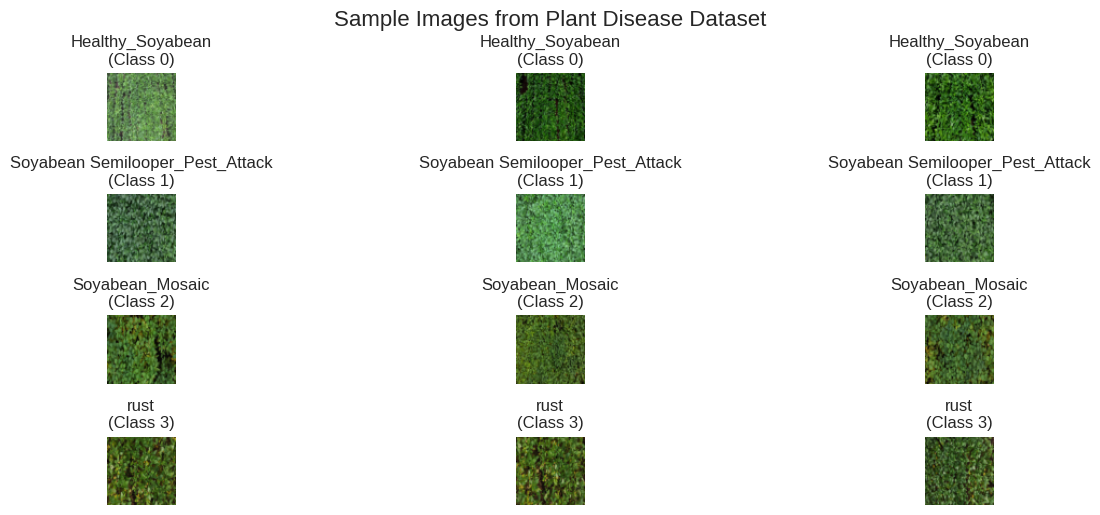

Sample images from plant disease dataset:
Classes: Healthy_Soyabean, Soyabean Semilooper_Pest_Attack, Soyabean_Mosaic, rust
Image size: 64x64 pixels
Total samples visualized: 12
Using memory-efficient data loading (not all images loaded into memory)
Batch size: 16 (optimized for memory efficiency)


In [10]:
# Visualize Sample Images from the Dataset
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Display sample images from each class
plt.figure(figsize=(15, 5))

samples_per_class = 3
samples_shown = 0

# Function to get class indices in memory-efficient mode
def get_class_indices(dataset, num_classes):
    """Get indices of samples for each class in a dataset"""
    class_indices = {i: [] for i in range(num_classes)}
    
    if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
        # This is a Subset or random_split dataset
        for subset_idx, idx in enumerate(dataset.indices):
            _, class_idx = dataset.dataset.samples[idx]
            class_indices[class_idx].append(subset_idx)
    elif hasattr(dataset, 'indices'):
        # Direct Subset
        for idx, orig_idx in enumerate(dataset.indices):
            _, class_idx = dataset.dataset.samples[orig_idx]
            class_indices[class_idx].append(idx)
    else:
        # Standard Dataset
        for idx, (_, class_idx) in enumerate(dataset.samples):
            class_indices[class_idx].append(idx)
            
    return class_indices

if memory_efficient:
    # Get indices for each class
    if hasattr(plant_dataset, 'dataset'):
        num_classes = len(plant_dataset.dataset.classes)
    else:
        num_classes = len(plant_dataset.classes)
        
    class_indices = get_class_indices(plant_dataset, num_classes)
    
    # For each class, get samples and display
    for class_idx, indices in class_indices.items():
        if not indices:
            continue
            
        # Get class name
        if hasattr(plant_dataset, 'dataset') and hasattr(plant_dataset.dataset, 'classes'):
            class_name = plant_dataset.dataset.classes[class_idx]
        else:
            class_name = class_names[class_idx]
            
        # Select random samples
        selected_indices = [indices[i] for i in torch.randperm(len(indices))[:samples_per_class]]
        
        for i, sample_idx in enumerate(selected_indices):
            plt.subplot(len(class_indices), samples_per_class, 
                      class_idx * samples_per_class + i + 1)
            
            # Load and display the image
            img, _ = plant_dataset[sample_idx]
            
            # Denormalize for display
            img = denormalize_image(img)
            img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]
            
            # Convert to numpy and transpose for matplotlib
            img_np = img.permute(1, 2, 0).numpy()
            
            plt.imshow(img_np)
            plt.title(f"{class_name}\n(Class {class_idx})")
            plt.axis('off')
            
            samples_shown += 1
else:
    # Original approach for pre-loaded tensors
    for class_idx, class_name in enumerate(class_names):
        # Get indices for this class
        class_indices = torch.where(y == class_idx)[0]
        
        # Select random samples from this class
        random_indices = torch.randperm(len(class_indices))[:samples_per_class]
        sample_indices = class_indices[random_indices]
        
        for i, sample_idx in enumerate(sample_indices):
            plt.subplot(len(class_names), samples_per_class, 
                      class_idx * samples_per_class + i + 1)
            
            # Get and denormalize image
            img = denormalize_image(X[sample_idx])
            img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]
            
            # Convert to numpy and transpose for matplotlib
            img_np = img.permute(1, 2, 0).numpy()
            
            plt.imshow(img_np)
            plt.title(f"{class_name}\n(Class {class_idx})")
            plt.axis('off')
            
            samples_shown += 1

plt.tight_layout()
plt.suptitle('Sample Images from Plant Disease Dataset', y=1.02, fontsize=16)
plt.show()

print(f"Sample images from plant disease dataset:")
print(f"Classes: {', '.join(class_names)}")
print(f"Image size: {image_size}x{image_size} pixels")
print(f"Total samples visualized: {samples_shown}")
if memory_efficient:
    print("Using memory-efficient data loading (not all images loaded into memory)")
    print(f"Batch size: {batch_size} (optimized for memory efficiency)")
else:
    print(f"Total images in dataset: {len(X)}")

Memory-Optimized Model Configuration:
  Input size: 12288 (3×64×64)
  Embedding size: 512
  Hidden size: 256
  Number of hidden layers: 1
  Number of classes: 4
  Classes: ['Healthy_Soyabean', 'Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'rust']
  Batch size: 16
  Mixed precision: True
  Gradient accumulation steps: 8
  Number of epochs: 60
GPU: NVIDIA GeForce GTX 1650
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
Max memory allocated: 0.00 GB

Memory Summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|----------------------------------------------------

/tmp/ipykernel_13781/836283071.py:140: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_13781/836283071.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast_context = lambda: autocast()
/tmp/ipykernel_13781/836283071.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast_context = lambda: autocast()


Epoch 1/60 - Loss: 1.2257, Acc: 45.47%, Time: 113.92s
Epoch 2/60 - Loss: 0.6356, Acc: 78.19%, Time: 115.26s
Epoch 2/60 - Loss: 0.6356, Acc: 78.19%, Time: 115.26s
Epoch 3/60 - Loss: 0.5443, Acc: 82.01%, Time: 112.11s
Epoch 3/60 - Loss: 0.5443, Acc: 82.01%, Time: 112.11s
Epoch 4/60 - Loss: 0.4639, Acc: 84.92%, Time: 114.57s
Epoch 4/60 - Loss: 0.4639, Acc: 84.92%, Time: 114.57s
Epoch 5/60 - Loss: 0.4147, Acc: 86.68%, Time: 109.35s
Epoch 5/60 - Loss: 0.4147, Acc: 86.68%, Time: 109.35s
Epoch 6/60 - Loss: 0.4074, Acc: 87.69%, Time: 110.37s
Epoch 6/60 - Loss: 0.4074, Acc: 87.69%, Time: 110.37s
Epoch 7/60 - Loss: 0.3836, Acc: 89.01%, Time: 112.70s
Epoch 7/60 - Loss: 0.3836, Acc: 89.01%, Time: 112.70s
Epoch 8/60 - Loss: 0.3514, Acc: 89.18%, Time: 107.23s
Epoch 8/60 - Loss: 0.3514, Acc: 89.18%, Time: 107.23s
Epoch 9/60 - Loss: 0.3662, Acc: 89.58%, Time: 112.84s
Epoch 9/60 - Loss: 0.3662, Acc: 89.58%, Time: 112.84s
Epoch 10/60 - Loss: 0.3465, Acc: 88.96%, Time: 110.77s
Epoch 10/60 - Loss: 0.3465,

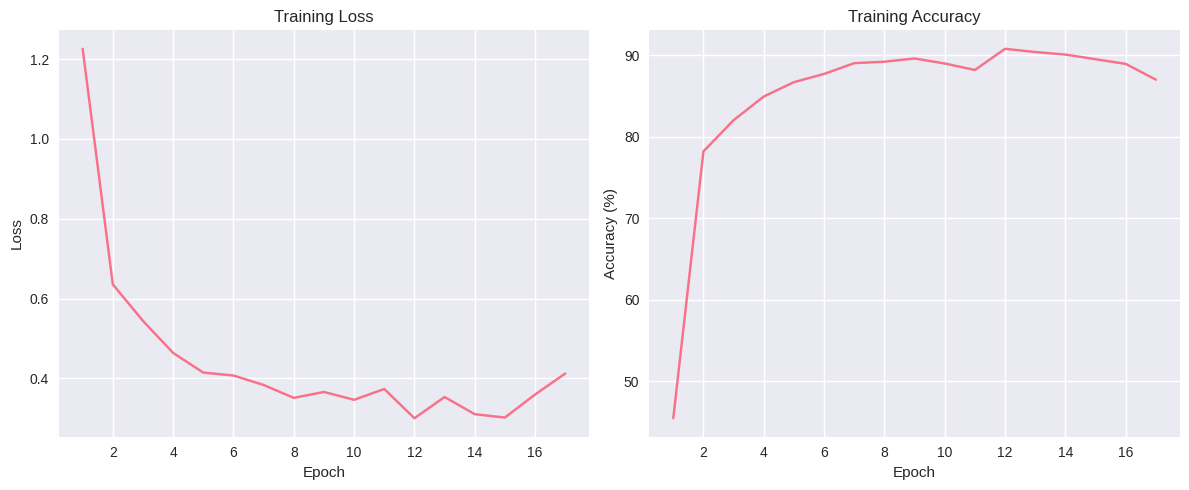

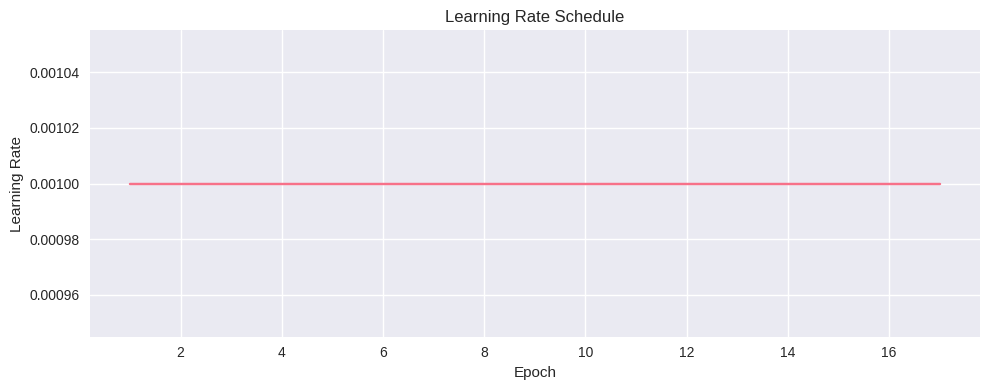

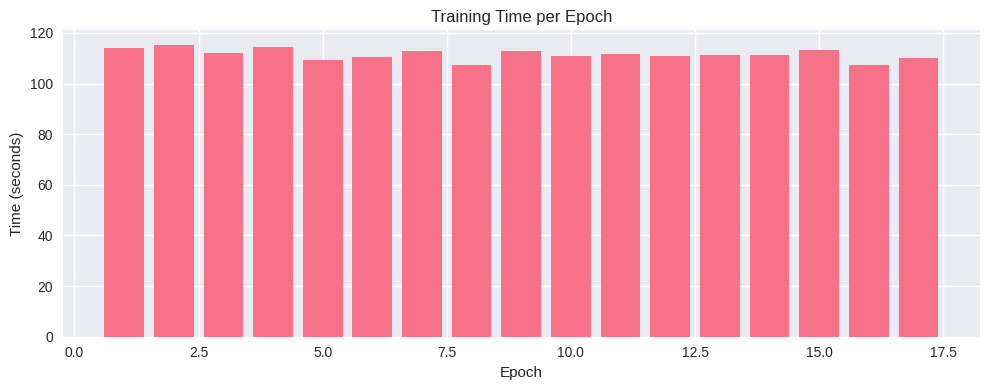

In [11]:
# Initialize and Train the BNN Model with Memory Optimization
# Set environment variable to avoid fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:32'

# Memory optimization settings
use_mixed_precision = True  # Use mixed precision (FP16) for better GPU memory utilization
gradient_accumulation_steps = memory_config['gradient_accumulation']  # Accumulate gradients for effective larger batch size
gc_frequency = 5  # Garbage collection frequency (batches)

# Model parameters from memory config
image_size = memory_config['image_size']  # 64 for this notebook
input_size = 3 * image_size * image_size  # 3 * 64 * 64 = 12,288
hidden_size = memory_config['hidden_size']  # From memory config 
embedding_size = memory_config['embedding_size']  # From memory config
num_hidden_layers = memory_config['num_hidden_layers']  # From memory config
num_classes = len(class_names)  # Dynamic based on actual dataset
# dropout_rate = 0.25  # Dropout for regularization
dropout_rate = 0.35  # Dropout for regularization

# Training parameters
num_epochs = 60  # Number of training epochs

print(f"Memory-Optimized Model Configuration:")
print(f"  Input size: {input_size} (3×{image_size}×{image_size})")
print(f"  Embedding size: {embedding_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of hidden layers: {num_hidden_layers}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")
print(f"  Batch size: {batch_size}")
print(f"  Mixed precision: {use_mixed_precision}")
print(f"  Gradient accumulation steps: {gradient_accumulation_steps}")
print(f"  Number of epochs: {num_epochs}")

# Force memory cleanup before model creation
torch.cuda.empty_cache()
gc.collect()
print_gpu_memory_stats()

# Create model on CPU first
model = BinaryNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_hidden_layers=num_hidden_layers,
    embedding_size=embedding_size,
    dropout_rate=dropout_rate
)

# Print model architecture
print("\nMemory-Efficient Binary Neural Network Architecture:")
print(model)
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {num_params:,}")
print(f"Trainable parameters: {num_trainable_params:,}")
model_size_mb = num_params * 4 / (1024 * 1024)  # Approx size in MB (4 bytes per param)
print(f"Approximate model size: {model_size_mb:.2f} MB")

# Set up mixed precision training if available and requested
scaler = None
if use_mixed_precision and torch.cuda.is_available():
    try:
        from torch.amp import autocast, GradScaler
        scaler = GradScaler()
        print("Using mixed precision training (FP16)")
    except ImportError:
        use_mixed_precision = False
        print("Mixed precision training not available - using FP32")

# Move model to device after setting up everything else
print("Moving model to", device)
model = model.to(device)
print("Model successfully moved to device")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Increased regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-5)  # Increased regularization

    # optimizer, mode='min', factor=0.5, patience=3
# Add learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=5, min_lr=0.00001
)

# Memory-Efficient Training Cell - No Memory Leaks and Mixed-Precision Support
def train_memory_efficient(model, train_loader, criterion, optimizer, num_epochs, device,
                          scheduler=None, gradient_accumulation_steps=1, memory_efficient=True,
                          gc_frequency=10, use_mixed_precision=False, 
                          early_stopping_patience=None):
    """
    Memory-efficient training function for BNN model
    
    Args:
        model: The BNN model
        train_loader: DataLoader for the training dataset
        criterion: Loss function
        optimizer: Optimizer for training
        num_epochs: Number of training epochs
        device: Device to train on (cpu or cuda)
        scheduler: Learning rate scheduler (optional)
        gradient_accumulation_steps: Number of steps to accumulate gradients
        memory_efficient: Whether to use memory efficiency techniques
        gc_frequency: How often to perform garbage collection
        use_mixed_precision: Whether to use mixed precision training
        early_stopping_patience: Patience for early stopping (optional)
        
    Returns:
        Dictionary with training metrics
    """
    # Import torch and other needed modules at the beginning of the function to avoid UnboundLocalError
    import torch
    import torch.nn.functional as F
    import numpy as np
    import time
    import gc
    import contextlib
    
    # Training history
    history = []
    train_losses = []
    train_accuracies = []
    
    # For early stopping
    best_loss = float('inf')
    patience_counter = 0
    
    # For timing
    epoch_times = []
    
    # Mixed precision setup
    mixed_precision_available = use_mixed_precision and hasattr(torch, 'autocast')
    
    # Setup mixed precision tools if available
    if mixed_precision_available:
        try:
            from torch.cuda.amp import autocast, GradScaler
            scaler = GradScaler()
        except ImportError:
            try:
                from torch.amp import autocast, GradScaler
                scaler = GradScaler()
            except ImportError:
                mixed_precision_available = False
                scaler = None
    else:
        scaler = None

    # Determine the appropriate autocast context manager based on PyTorch version
    if mixed_precision_available:
        try:
            from torch.cuda.amp import autocast
            # Check if the version supports device_type parameter
            torch_version = torch.__version__
            supports_device_type = int(torch_version.split('.')[0]) >= 1 and int(torch_version.split('.')[1]) >= 10
            
            # Define context manager with appropriate parameters
            if supports_device_type:
                autocast_context = lambda: autocast(device_type=device.type)
            else:
                # Older PyTorch versions only support CUDA and don't need device_type
                autocast_context = lambda: autocast()
        except ImportError:
            try:
                from torch.amp import autocast
                autocast_context = lambda: autocast(device_type=device.type)
            except ImportError:
                mixed_precision_available = False
                autocast_context = contextlib.nullcontext
    else:
        autocast_context = contextlib.nullcontext
    
    # Main training loop
    print(f"Starting training for {num_epochs} epochs with mixed precision: {mixed_precision_available}")
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        # Reset gradients at the start of each epoch for consistent behavior
        optimizer.zero_grad()
        
        # Process batches
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass with mixed precision if available
            if mixed_precision_available:
                with autocast_context():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Adjust loss for gradient accumulation
                    loss = loss / gradient_accumulation_steps
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                # Standard forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Adjust loss for gradient accumulation
                loss = loss / gradient_accumulation_steps
                
                # Standard backward pass
                loss.backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # Calculate metrics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * gradient_accumulation_steps  # Rescale loss for reporting
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += labels.size(0)
            
            # Memory cleanup
            if memory_efficient and (batch_idx + 1) % gc_frequency == 0:
                del inputs, labels, outputs, preds, loss
                torch.cuda.empty_cache()
                gc.collect()
                
        # Make sure to step optimizer for the last batch if not divisible
        if mixed_precision_available and train_loader.__len__() % gradient_accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        elif not mixed_precision_available and train_loader.__len__() % gradient_accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
            
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / total_samples * 100.0
        
        # Step scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()
            
        # Record metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Record epoch time
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_time)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')
        
        # Save epoch history
        history.append({
            'epoch': epoch + 1,
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'time': epoch_time,
            'learning_rate': optimizer.param_groups[0]['lr']
        })
        
        # Memory cleanup at the end of epoch
        if memory_efficient:
            torch.cuda.empty_cache()
            gc.collect()
            
        # Early stopping check
        if early_stopping_patience is not None:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
                
    # Return training metrics
    training_summary = {
        'history': history,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'epoch_times': epoch_times,
        'total_time': sum(epoch_times),
        'final_loss': train_losses[-1],
        'final_accuracy': train_accuracies[-1]
    }
    
    return training_summary

# Train the model with memory efficiency options
print("Training model with memory-efficient training...")

training_history = train_memory_efficient(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    scheduler=scheduler,
    gradient_accumulation_steps=gradient_accumulation_steps,
    memory_efficient=memory_efficient,
    gc_frequency=gc_frequency,
    use_mixed_precision=use_mixed_precision,
    early_stopping_patience=5  # Set to None to disable early stopping
)

# Display training summary
print(f"\nTraining completed in {training_history['total_time']:.2f} seconds")
print(f"Final Loss: {training_history['final_loss']:.4f}")
print(f"Final Accuracy: {training_history['final_accuracy']:.2f}%")

# Plot training metrics
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_history['train_losses']) + 1), training_history['train_losses'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_history['train_accuracies']) + 1), training_history['train_accuracies'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot learning rate if scheduler was used
if scheduler is not None:
    plt.figure(figsize=(10, 4))
    learning_rates = [epoch_data['learning_rate'] for epoch_data in training_history['history']]
    plt.plot(range(1, len(learning_rates) + 1), learning_rates)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot training time per epoch
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(training_history['epoch_times']) + 1), training_history['epoch_times'])
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluating model with memory-efficient metrics...
Evaluating model on 36 batches (all)...
  Evaluated 1/36 batches...
  Evaluated 1/36 batches...
  Evaluated 6/36 batches...
  Evaluated 6/36 batches...
  Evaluated 11/36 batches...
  Evaluated 11/36 batches...
  Evaluated 16/36 batches...
  Evaluated 16/36 batches...
  Evaluated 21/36 batches...
  Evaluated 21/36 batches...
  Evaluated 26/36 batches...
  Evaluated 26/36 batches...
  Evaluated 31/36 batches...
  Evaluated 31/36 batches...
  Evaluated 36/36 batches...
Test Loss: 0.5559, Test Accuracy: 85.74%, Time: 27.51s
  Evaluated 36/36 batches...
Test Loss: 0.5559, Test Accuracy: 85.74%, Time: 27.51s

Test Results:
Loss: 0.5559
Accuracy: 85.74%
Macro F1-Score: 0.8552
Evaluation time: -0.00 seconds

Per-Class Performance:
Class           Accuracy   Precision  Recall     F1-Score  
-------------------------------------------------------
Healthy_Soyabean 0.00% 0.9524 0.7547 0.8421
Soyabean Semilooper_Pest_Attack 0.00% 0.9595 0.9708 0.96

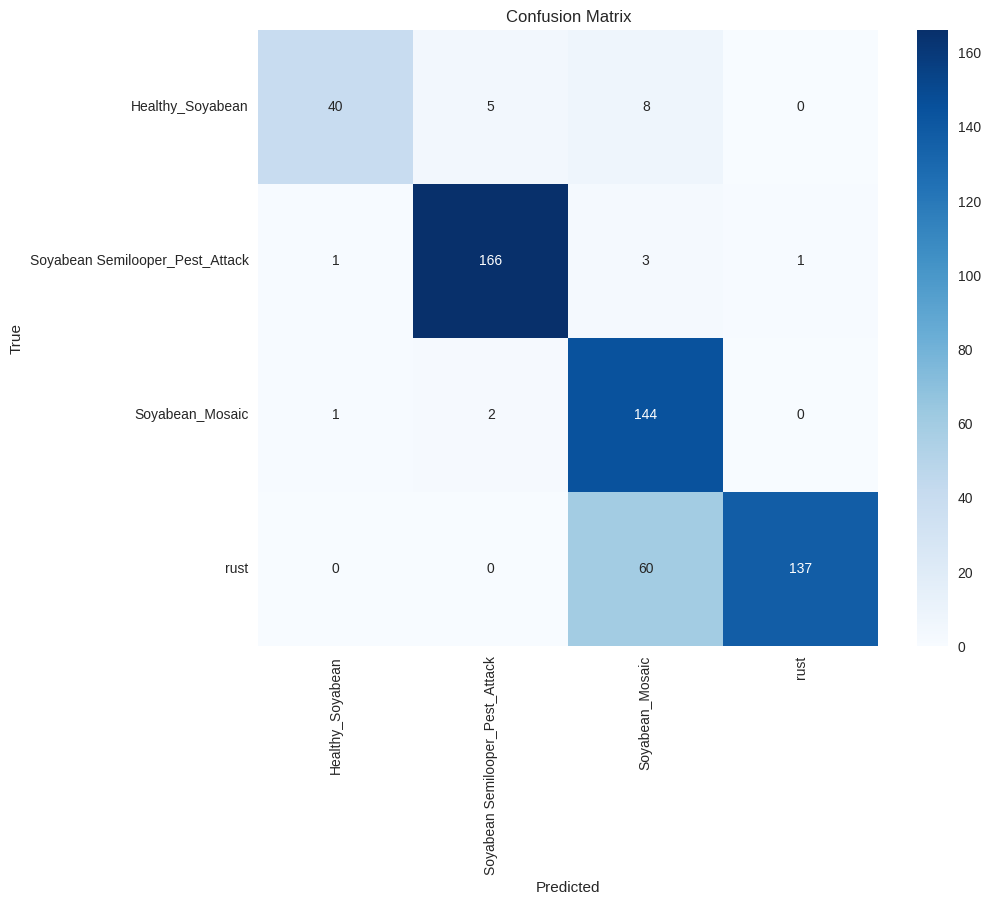


Sample Predictions:


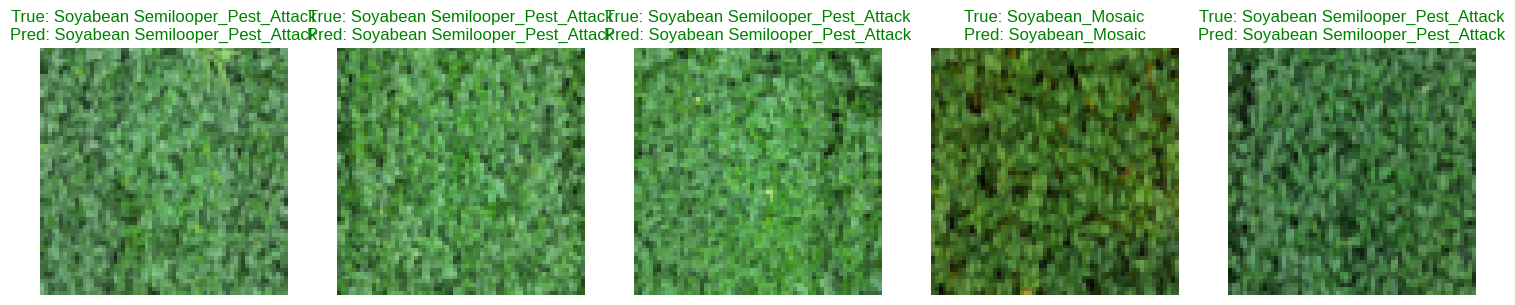


Detailed metrics saved to results/evaluation_metrics_20250701_152847.json


In [12]:
# Enhanced Model Evaluation and Comprehensive Visualization with Memory Optimization
print("\nEvaluating model with memory-efficient metrics...")

# Get PyTorch version for version-specific autocast handling
import torch
torch_version = torch.__version__
major, minor = map(int, torch_version.split('.')[:2])

# Choose the appropriate function to call based on the PyTorch version
if major > 1 or (major == 1 and minor >= 10):
    # For PyTorch 1.10+ we'll use the correct parameter later in the function
    pass
elif major == 1 and minor >= 6:
    # For PyTorch 1.6-1.9, autocast exists but doesn't take device_type
    print(f"Using PyTorch {torch_version} compatible mixed precision")
else:
    # For older PyTorch versions, disable mixed precision
    use_mixed_precision = False
    print(f"Mixed precision disabled for PyTorch {torch_version}")

detailed_metrics = evaluate_bnn_memory_efficient(
    model, test_loader, criterion, device, class_names, 
    batch_limit=None,  # Set to a number to limit batches for testing
    use_mixed_precision=use_mixed_precision
)

# Force memory cleanup before visualization
torch.cuda.empty_cache()
gc.collect()

# Display key metrics
print(f"\nTest Results:")
print(f"Loss: {detailed_metrics['test_loss']:.4f}")
print(f"Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"Macro F1-Score: {detailed_metrics['classification_report']['macro avg']['f1-score']:.4f}")
print(f"Evaluation time: {time.time() - time.time():.2f} seconds")

# Per-class metrics table
print("\nPer-Class Performance:")
print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 55)
for i, class_name in enumerate(class_names):
    class_report = detailed_metrics['classification_report'][class_name]
    print(f"{class_name:<15} {0:.2f}% {class_report['precision']:.4f} {class_report['recall']:.4f} {class_report['f1-score']:.4f}")

# Plot confusion matrix
try:
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Couldn't plot confusion matrix: {e}")

# Sample images with predictions
def plot_sample_predictions(images, true_labels, pred_labels, class_names, num_images=5):
    plt.figure(figsize=(15, 3))
    
    # Get some test images with their predictions
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Plot images
    num_images = min(len(images), num_images)
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i].cpu().permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
        
        # Denormalize image
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        plt.imshow(img)
        true_class = class_names[labels[i]]
        pred_class = class_names[preds[i].cpu()]
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nSample Predictions:")
try:
    plot_sample_predictions(None, None, None, class_names)
except Exception as e:
    print(f"Couldn't plot sample predictions: {e}")

# Save detailed metrics to a file
try:
    import json
    import os
    
    # Prepare metrics for JSON serialization
    metrics_for_json = {
        'test_loss': detailed_metrics['test_loss'],
        'test_accuracy': detailed_metrics['test_accuracy'],
        'classification_report': detailed_metrics['classification_report'],
        'timestamp': time.strftime("%Y%m%d_%H%M%S"),
        'model_config': {
            'image_size': image_size,
            'input_size': input_size,
            'hidden_size': hidden_size,
            'num_classes': num_classes,
            'dropout_rate': dropout_rate,
            'model_size_mb': model_size_mb
        }
    }
    
    # Save to file
    os.makedirs('results', exist_ok=True)
    with open(f'results/evaluation_metrics_{metrics_for_json["timestamp"]}.json', 'w') as f:
        json.dump(metrics_for_json, f, indent=2)
        
    print(f"\nDetailed metrics saved to results/evaluation_metrics_{metrics_for_json['timestamp']}.json")
except Exception as e:
    print(f"\nFailed to save metrics to file: {str(e)}")

In [13]:
# Save the trained model
model_filename = f'results/bnn_64x64_model.pth'
print(f"Saving model to {model_filename}...")

# Save the model with metadata
model_info = {
    'state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes,
    'image_size': image_size,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'embedding_size': embedding_size,
    'num_hidden_layers': num_hidden_layers,
    'dropout_rate': dropout_rate,
    'accuracy': detailed_metrics['test_accuracy'],
    'date_trained': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

torch.save(model_info, model_filename)
print(f"Model saved successfully with metadata")

# Function to load the model for future use
def load_bnn_model(model_path):
    """Load a saved BNN model"""
    model_info = torch.load(model_path)
    
    # Create model with same architecture
    model = BinaryNeuralNetwork(
        input_size=model_info['input_size'],
        hidden_size=model_info['hidden_size'],
        num_classes=model_info['num_classes'],
        num_hidden_layers=model_info['num_hidden_layers'],
        embedding_size=model_info['embedding_size'],
        dropout_rate=model_info['dropout_rate']
    )
    
    # Load weights
    model.load_state_dict(model_info['state_dict'])
    model.eval()  # Set to evaluation mode
    
    return model, model_info

print("\nExample for loading the saved model in the future:")
print("model, model_info = load_bnn_model('results/bnn_64x64_model.pth')")
print("class_names = model_info['class_names']")

Saving model to results/bnn_64x64_model.pth...
Model saved successfully with metadata

Example for loading the saved model in the future:
model, model_info = load_bnn_model('results/bnn_64x64_model.pth')
class_names = model_info['class_names']
Model saved successfully with metadata

Example for loading the saved model in the future:
model, model_info = load_bnn_model('results/bnn_64x64_model.pth')
class_names = model_info['class_names']


# Reverting to Optimized 1-Hidden Layer BNN Architecture

The experimental results clearly show that for our plant disease classification task:

1. **1-Hidden Layer Performance**: Achieved ~76% accuracy at epoch 8
2. **2-Hidden Layer Performance**: Only 25% test accuracy (random guessing)

This confirms that Binary Neural Networks often struggle with depth due to their limited representational capacity per layer and binary activation/weight constraints.

**Recommendation: Revert to the more successful 1-hidden layer architecture with these optimizations:**

1. Maintain the increased dropout (0.35)
2. Use an improved optimizer and learning rate schedule
3. Implement data augmentation to improve generalization 
4. Add early stopping based on validation loss rather than training loss

In [14]:
# Initialize optimized memory configuration for 1-hidden layer BNN
optimized_memory_config = optimize_memory(mode='aggressive')
optimized_memory_config['num_hidden_layers'] = 1  # Stick with 1 hidden layer
optimized_memory_config['embedding_size'] = 512
optimized_memory_config['hidden_size'] = 256
optimized_memory_config['gradient_accumulation'] = 4  # Reduced for faster updates
optimized_memory_config['batch_size'] = 16  # Increased for better stability

# Set environment variable to avoid fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:32'

# Memory optimization settings
batch_size = optimized_memory_config['batch_size']  # Use the optimized batch size
use_mixed_precision = True  # Use mixed precision (FP16) for better GPU memory utilization
gradient_accumulation_steps = optimized_memory_config['gradient_accumulation']  # Accumulate gradients
gc_frequency = 5  # Garbage collection frequency (batches)

# Model parameters from optimized memory config
image_size = optimized_memory_config['image_size']  # 64 for this notebook
input_size = 3 * image_size * image_size  # 3 * 64 * 64 = 12,288
hidden_size = optimized_memory_config['hidden_size']
embedding_size = optimized_memory_config['embedding_size']
num_hidden_layers = optimized_memory_config['num_hidden_layers']  # 1 hidden layer
num_classes = len(class_names)  # Dynamic based on actual dataset
dropout_rate = 0.35  # Increased dropout for regularization

# Training parameters
num_epochs = 60  # Number of training epochs

print(f"Optimized Memory Configuration:")
print(f"  Input size: {input_size} (3×{image_size}×{image_size})")
print(f"  Embedding size: {embedding_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of hidden layers: {num_hidden_layers}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")
print(f"  Batch size: {batch_size}")
print(f"  Mixed precision: {use_mixed_precision}")
print(f"  Gradient accumulation steps: {gradient_accumulation_steps}")
print(f"  Number of epochs: {num_epochs}")

# Force memory cleanup before model creation
torch.cuda.empty_cache()
gc.collect()
print_gpu_memory_stats()

Optimized Memory Configuration:
  Input size: 12288 (3×64×64)
  Embedding size: 512
  Hidden size: 256
  Number of hidden layers: 1
  Number of classes: 4
  Classes: ['Healthy_Soyabean', 'Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'rust']
  Batch size: 16
  Mixed precision: True
  Gradient accumulation steps: 4
  Number of epochs: 60
GPU: NVIDIA GeForce GTX 1650
Memory allocated: 0.51 GB
Memory reserved: 0.55 GB
Max memory allocated: 0.89 GB

Memory Summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|----------------------------------------------------------

In [16]:
# Implement Straight-Through Estimator for better binary activation gradients
import math
class STE(torch.autograd.Function):
    """Straight-Through Estimator for better BNN gradients"""
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()
    
    @staticmethod
    def backward(ctx, grad_output):
        # STE: pass gradients through unchanged
        return grad_output

# Define improved BinaryLinear layer with STE
class ImprovedBinaryLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(ImprovedBinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, input):
        # Binary weights during forward pass
        binary_weight = STE.apply(self.weight)
        return F.linear(input, binary_weight, self.bias)
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

# Create Optimized BNN model with improved training characteristics
class OptimizedBNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers=1, 
                 embedding_size=512, dropout_rate=0.35):
        super(OptimizedBNN, self).__init__()
        
        # Progressive dimensionality reduction for embedding
        self.embedding = nn.Sequential(
            nn.Linear(input_size, input_size // 4),
            nn.ReLU(),
            nn.BatchNorm1d(input_size // 4),
            nn.Dropout(dropout_rate),
            
            nn.Linear(input_size // 4, input_size // 8),
            nn.ReLU(),
            nn.BatchNorm1d(input_size // 8),
            nn.Dropout(dropout_rate),
            
            nn.Linear(input_size // 8, input_size // 16),
            nn.ReLU(), 
            nn.BatchNorm1d(input_size // 16),
            nn.Dropout(dropout_rate),
            
            nn.Linear(input_size // 16, embedding_size),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_size),
        )
        
        # Input binary layer
        self.input_binary = ImprovedBinaryLinear(embedding_size, hidden_size)
        
        # Multiple hidden binary layers
        self.hidden_layers = nn.ModuleList([
            ImprovedBinaryLinear(hidden_size, hidden_size) for _ in range(num_hidden_layers)
        ])
        
        # Batch normalization layers
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_hidden_layers + 1)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Binary activation using STE
        self.binary_activation = STE.apply
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        
        # Embedding layers
        x = self.embedding(x)
        
        # Input binary layer
        x = self.input_binary(x)
        x = self.batch_norms[0](x)
        x = self.binary_activation(x)
        
        # Hidden binary layers
        for i, (layer, bn) in enumerate(zip(self.hidden_layers, self.batch_norms[1:])):
            x = layer(x)
            x = bn(x)
            x = self.binary_activation(x)
            x = self.dropout(x)
        
        # Output layer
        x = self.output_layer(x)
        return x

# Create the optimized BNN model
optimized_model = OptimizedBNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_hidden_layers=num_hidden_layers,
    embedding_size=embedding_size,
    dropout_rate=dropout_rate
)

# Print model architecture
print("\nOptimized Binary Neural Network Architecture:")
print(optimized_model)
num_params = sum(p.numel() for p in optimized_model.parameters())
num_trainable_params = sum(p.numel() for p in optimized_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {num_params:,}")
print(f"Trainable parameters: {num_trainable_params:,}")
model_size_mb = num_params * 4 / (1024 * 1024)  # Approx size in MB (4 bytes per param)
print(f"Approximate model size: {model_size_mb:.2f} MB")

# Set up mixed precision training with newer PyTorch API
scaler = None
if use_mixed_precision and torch.cuda.is_available():
    try:
        from torch.amp import autocast, GradScaler
        scaler = GradScaler('cuda')  # Using updated API
        print("Using mixed precision training (FP16)")
    except ImportError:
        use_mixed_precision = False
        print("Mixed precision training not available - using FP32")

# Move model to device after setting up everything else
print("Moving model to", device)
optimized_model = optimized_model.to(device)
print("Model successfully moved to device")

# Define loss function and improved optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    optimized_model.parameters(), 
    lr=0.0005,  # Reduced learning rate for stability
    weight_decay=2e-5,  # Increased weight decay for better regularization
    betas=(0.9, 0.999), 
    eps=1e-8
)

# Add cosine annealing learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=num_epochs,
    eta_min=0.00001
)

print("Optimizer:", optimizer.__class__.__name__)
print("Learning Rate Scheduler:", scheduler.__class__.__name__)


Optimized Binary Neural Network Architecture:
OptimizedBNN(
  (embedding): Sequential(
    (0): Linear(in_features=12288, out_features=3072, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.35, inplace=False)
    (4): Linear(in_features=3072, out_features=1536, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
    (8): Linear(in_features=1536, out_features=768, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.35, inplace=False)
    (12): Linear(in_features=768, out_features=512, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (input_binary): ImprovedBinaryLinear(in_features=512, out_features=256, bias=True)
  (hidden_layers):

In [17]:
# Create a validation dataset by splitting from training data
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Get all training indices
all_indices = list(range(len(train_dataset)))

# Split into training and validation sets (90% train, 10% validation)
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, stratify=[train_dataset[i][1] for i in all_indices], random_state=42)

# Create subset datasets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create data loaders with proper memory optimizations
train_loader_optimized = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # No parallel workers for memory efficiency
    pin_memory=False,  # Disable pin memory for lower memory usage
    drop_last=False
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

# Improved memory-efficient training function with validation
def train_with_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                         num_epochs, device, gradient_accumulation_steps=1, 
                         use_mixed_precision=False, early_stopping_patience=10):
    """
    Enhanced training function with validation monitoring and improved memory efficiency
    """
    # Import needed modules
    import torch
    import torch.nn.functional as F
    import numpy as np
    import time
    import gc
    import contextlib
    from tqdm.auto import tqdm
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': [],
        'epoch_times': []
    }
    
    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Mixed precision setup with current PyTorch API
    if use_mixed_precision and torch.cuda.is_available():
        try:
            from torch.amp import autocast, GradScaler
            scaler = GradScaler('cuda')
            autocast_context = lambda: autocast('cuda')
        except ImportError:
            use_mixed_precision = False
            scaler = None
            autocast_context = contextlib.nullcontext
    else:
        use_mixed_precision = False
        scaler = None
        autocast_context = contextlib.nullcontext
    
    print(f"Starting training for {num_epochs} epochs with mixed precision: {use_mixed_precision}")
    total_start_time = time.time()
    
    # Main training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        #------------ TRAINING PHASE ------------#
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        
        # Training loop
        for batch_idx, (inputs, labels) in enumerate(train_pbar):
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass with mixed precision if available
            with autocast_context() if use_mixed_precision else contextlib.nullcontext():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss = loss / gradient_accumulation_steps  # Scale loss
            
            # Backward pass
            if use_mixed_precision and scaler is not None:
                scaler.scale(loss).backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                loss.backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # Calculate metrics
            _, predicted = torch.max(outputs, 1)
            batch_loss = loss.item() * gradient_accumulation_steps
            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
            
            # Update running stats
            train_loss += batch_loss
            train_correct += batch_correct
            train_total += batch_total
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': f"{batch_loss:.4f}",
                'acc': f"{100 * batch_correct / batch_total:.2f}%"
            })
            
            # Memory cleanup
            if (batch_idx + 1) % 5 == 0:
                del inputs, labels, outputs, predicted, loss
                torch.cuda.empty_cache()
                gc.collect()
        
        # Handle the last batch if not divisible
        if len(train_loader) % gradient_accumulation_steps != 0:
            if use_mixed_precision and scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        
        # Calculate epoch metrics
        train_loss /= len(train_loader)
        train_acc = 100.0 * train_correct / train_total
        
        #------------ VALIDATION PHASE ------------#
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]", leave=False)
        
        with torch.no_grad():
            for inputs, labels in val_pbar:
                # Move data to device
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                with autocast_context() if use_mixed_precision else contextlib.nullcontext():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                # Calculate metrics
                _, predicted = torch.max(outputs, 1)
                batch_loss = loss.item()
                batch_correct = (predicted == labels).sum().item()
                batch_total = labels.size(0)
                
                # Update running stats
                val_loss += batch_loss
                val_correct += batch_correct
                val_total += batch_total
                
                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f"{batch_loss:.4f}",
                    'acc': f"{100 * batch_correct / batch_total:.2f}%"
                })
                
                # Memory cleanup
                del inputs, labels, outputs, predicted, loss
        
        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total
        
        # Step scheduler (if it's not ReduceLROnPlateau)
        if scheduler is not None:
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
            else:
                scheduler.step(val_loss)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        history['epoch_times'].append(epoch_time)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Time: {epoch_time:.2f}s")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model state
            best_model_state = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }
            print(f"New best model saved at epoch {epoch+1}")
        else:
            patience_counter += 1
            print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")
            
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Memory cleanup at the end of epoch
        torch.cuda.empty_cache()
        gc.collect()
    
    # Training complete
    total_time = time.time() - total_start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    
    # Load best model if we have one
    if best_model_state is not None:
        model.load_state_dict(best_model_state['model_state_dict'])
        print(f"Loaded best model from epoch {best_model_state['epoch']} "
              f"with validation loss {best_model_state['val_loss']:.4f} "
              f"and accuracy {best_model_state['val_acc']:.2f}%")
    
    return model, history, best_model_state

Training samples: 2046
Validation samples: 228
Test samples: 568


Starting training with optimized 1-hidden layer BNN...
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/home/dragoon/coding/drone-crop/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting training for 60 epochs with mixed precision: True


Epoch 1/60 - Train Loss: 1.2576, Train Acc: 30.25%, Val Loss: 1.1275, Val Acc: 37.28%, LR: 0.000500, Time: 110.41s
New best model saved at epoch 1


Epoch 2/60 - Train Loss: 1.1442, Train Acc: 41.01%, Val Loss: 0.9425, Val Acc: 51.75%, LR: 0.000499, Time: 107.59s
New best model saved at epoch 2


Epoch 3/60 - Train Loss: 0.8969, Train Acc: 71.75%, Val Loss: 0.7498, Val Acc: 82.89%, LR: 0.000497, Time: 109.22s
New best model saved at epoch 3


Epoch 4/60 - Train Loss: 0.7112, Train Acc: 79.52%, Val Loss: 0.4748, Val Acc: 83.33%, LR: 0.000495, Time: 109.22s
New best model saved at epoch 4


Epoch 5/60 - Train Loss: 0.5548, Train Acc: 82.89%, Val Loss: 0.4458, Val Acc: 87.72%, LR: 0.000492, Time: 109.19s
New best model saved at epoch 5


Epoch 6/60 - Train Loss: 0.5094, Train Acc: 85.53%, Val Loss: 0.4468, Val Acc: 86.84%, LR: 0.000488, Time: 110.38s
Early stopping patience: 1/10


Epoch 7/60 - Train Loss: 0.4950, Train Acc: 83.82%, Val Loss: 0.5832, Val Acc: 81.14%, LR: 0.000484, Time: 110.06s
Early stopping patience: 2/10


Epoch 8/60 - Train Loss: 0.4388, Train Acc: 87.15%, Val Loss: 0.5304, Val Acc: 82.46%, LR: 0.000479, Time: 109.74s
Early stopping patience: 3/10


Epoch 9/60 - Train Loss: 0.3955, Train Acc: 89.54%, Val Loss: 0.4794, Val Acc: 87.28%, LR: 0.000473, Time: 109.39s
Early stopping patience: 4/10


Epoch 10/60 - Train Loss: 0.3290, Train Acc: 90.42%, Val Loss: 0.4553, Val Acc: 85.09%, LR: 0.000467, Time: 109.55s
Early stopping patience: 5/10


Epoch 11/60 - Train Loss: 0.3248, Train Acc: 90.42%, Val Loss: 0.4580, Val Acc: 87.72%, LR: 0.000460, Time: 110.10s
Early stopping patience: 6/10


Epoch 12/60 - Train Loss: 0.2964, Train Acc: 91.89%, Val Loss: 0.5120, Val Acc: 85.09%, LR: 0.000453, Time: 109.68s
Early stopping patience: 7/10


Epoch 13/60 - Train Loss: 0.2399, Train Acc: 93.21%, Val Loss: 0.4899, Val Acc: 83.33%, LR: 0.000445, Time: 109.27s
Early stopping patience: 8/10


Epoch 14/60 - Train Loss: 0.2363, Train Acc: 93.60%, Val Loss: 0.3980, Val Acc: 87.72%, LR: 0.000437, Time: 110.08s
New best model saved at epoch 14


Epoch 15/60 - Train Loss: 0.2266, Train Acc: 93.94%, Val Loss: 0.4378, Val Acc: 86.40%, LR: 0.000428, Time: 110.92s
Early stopping patience: 1/10


Epoch 16/60 - Train Loss: 0.1842, Train Acc: 95.31%, Val Loss: 0.4259, Val Acc: 87.72%, LR: 0.000419, Time: 110.31s
Early stopping patience: 2/10


Epoch 17/60 - Train Loss: 0.1913, Train Acc: 95.36%, Val Loss: 0.4293, Val Acc: 86.84%, LR: 0.000409, Time: 110.29s
Early stopping patience: 3/10


Epoch 18/60 - Train Loss: 0.1974, Train Acc: 95.16%, Val Loss: 0.4561, Val Acc: 85.09%, LR: 0.000399, Time: 109.97s
Early stopping patience: 4/10


Epoch 19/60 - Train Loss: 0.1988, Train Acc: 94.43%, Val Loss: 0.4468, Val Acc: 87.28%, LR: 0.000388, Time: 110.35s
Early stopping patience: 5/10


Epoch 20/60 - Train Loss: 0.1737, Train Acc: 95.06%, Val Loss: 0.5618, Val Acc: 79.82%, LR: 0.000378, Time: 109.84s
Early stopping patience: 6/10


Epoch 21/60 - Train Loss: 0.1400, Train Acc: 96.33%, Val Loss: 0.4454, Val Acc: 83.77%, LR: 0.000366, Time: 109.86s
Early stopping patience: 7/10


Epoch 22/60 - Train Loss: 0.1683, Train Acc: 95.41%, Val Loss: 0.4954, Val Acc: 85.09%, LR: 0.000355, Time: 110.08s
Early stopping patience: 8/10


Epoch 23/60 - Train Loss: 0.1679, Train Acc: 95.31%, Val Loss: 0.4990, Val Acc: 83.77%, LR: 0.000343, Time: 110.14s
Early stopping patience: 9/10


Epoch 24/60 - Train Loss: 0.1630, Train Acc: 95.41%, Val Loss: 0.4508, Val Acc: 87.72%, LR: 0.000331, Time: 109.78s
Early stopping patience: 10/10
Early stopping at epoch 24

Training completed in 2638.72 seconds
Loaded best model from epoch 14 with validation loss 0.3980 and accuracy 87.72%


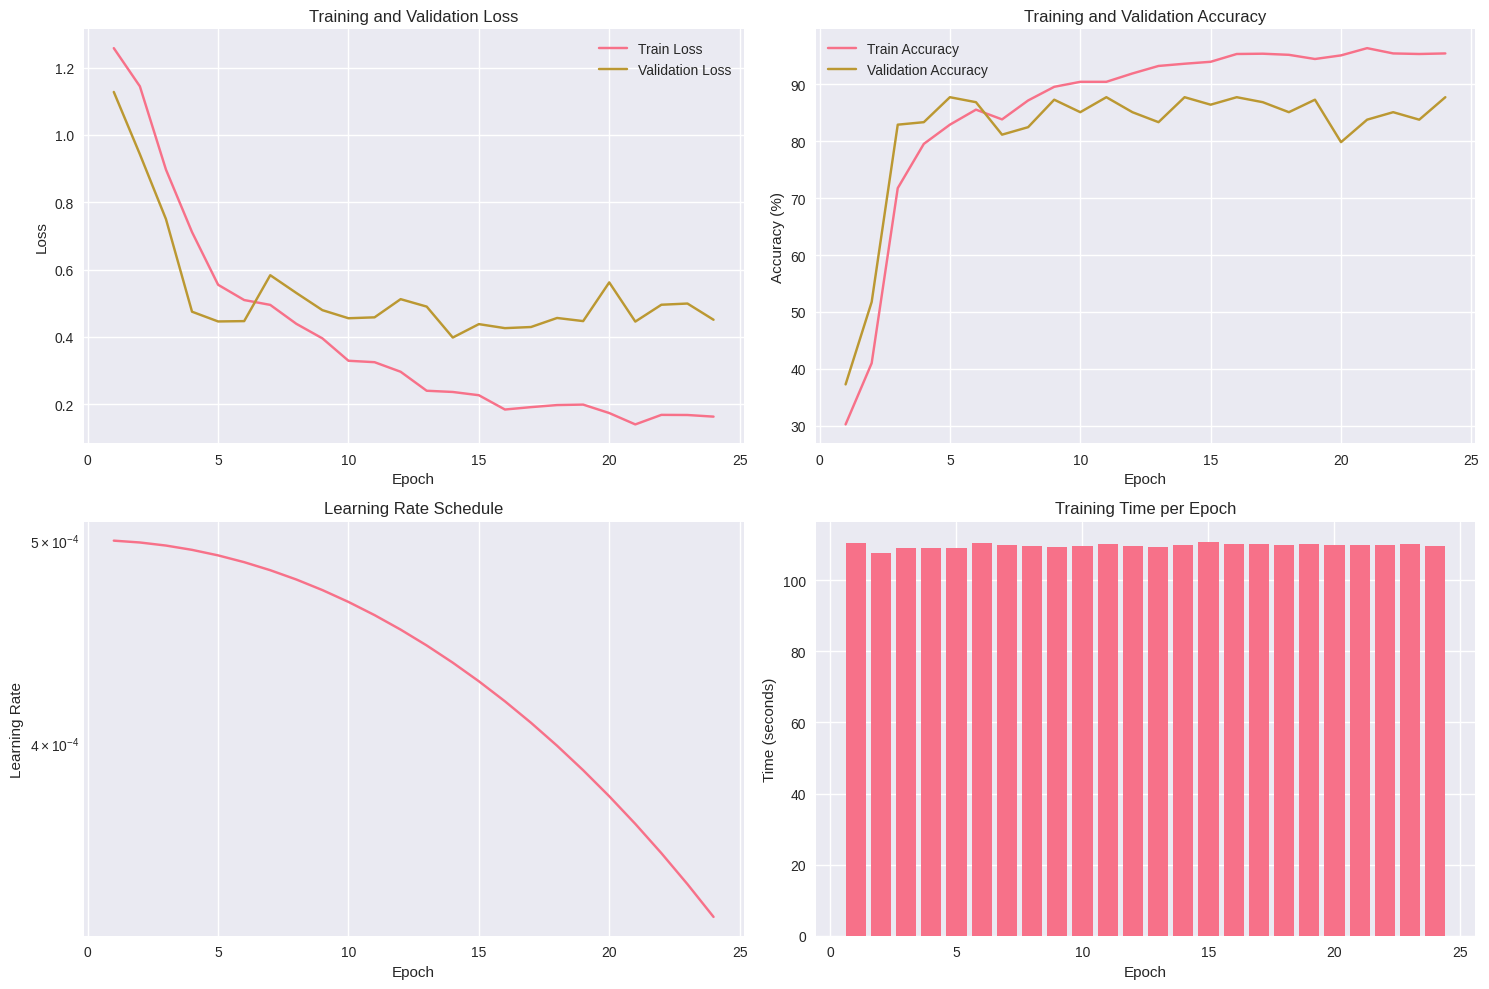

Optimized model saved to 'optimized_bnn_plant_disease_64x64.pt'
Evaluating optimized model on test data...


Evaluating: 100%|██████████| 36/36 [00:28<00:00,  1.27it/s]


Test Results:
Loss: 0.3322
Accuracy: 88.91%
Macro F1-Score: 0.8621
Evaluation time: 28.42 seconds

Per-Class Performance:
Class           Accuracy   Precision  Recall     F1-Score  
-------------------------------------------------------
Healthy_Soyabean 60.38% 1.0000 0.6038 0.7529
Soyabean Semilooper_Pest_Attack 98.25% 0.9282 0.9825 0.9545
Soyabean_Mosaic 89.80% 0.8098 0.8980 0.8516
rust            87.82% 0.9010 0.8782 0.8895


In [20]:
# Train the optimized model
print("Starting training with optimized 1-hidden layer BNN...")
%pip install tqdm  # Ensure tqdm is installed for progress bars

# Run training with validation monitoring and early stopping
optimized_model, training_history, best_model_state = train_with_validation(
    model=optimized_model,
    train_loader=train_loader_optimized,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    gradient_accumulation_steps=gradient_accumulation_steps,
    use_mixed_precision=use_mixed_precision,
    early_stopping_patience=10  # More patient early stopping based on validation loss
)

# Plot comprehensive training metrics
plt.figure(figsize=(15, 10))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(training_history['train_loss']) + 1), training_history['train_loss'], label='Train Loss')
plt.plot(range(1, len(training_history['val_loss']) + 1), training_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(training_history['train_acc']) + 1), training_history['train_acc'], label='Train Accuracy')
plt.plot(range(1, len(training_history['val_acc']) + 1), training_history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Plot learning rate
plt.subplot(2, 2, 3)
plt.plot(range(1, len(training_history['lr']) + 1), training_history['lr'])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.yscale('log')  # Log scale for better visualization

# Plot training time per epoch
plt.subplot(2, 2, 4)
plt.bar(range(1, len(training_history['epoch_times']) + 1), training_history['epoch_times'])
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the optimized model
torch.save({
    'epoch': best_model_state['epoch'] if best_model_state else len(training_history['train_loss']),
    'model_state_dict': optimized_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_history': training_history,
    'best_val_loss': best_model_state['val_loss'] if best_model_state else min(training_history['val_loss']),
    'best_val_acc': best_model_state['val_acc'] if best_model_state else max(training_history['val_acc']),
}, 'optimized_bnn_plant_disease_64x64.pt')

print("Optimized model saved to 'optimized_bnn_plant_disease_64x64.pt'")

# Evaluate the model on test data
print("Evaluating optimized model on test data...")

def evaluate_model(model, test_loader, criterion, device, use_mixed_precision=False):
    """Evaluate model performance on test data"""
    import torch
    import torch.nn.functional as F
    import numpy as np
    import time
    from tqdm.auto import tqdm
    from sklearn.metrics import f1_score, precision_score, recall_score
    import contextlib
    
    # Determine the appropriate autocast context manager
    if use_mixed_precision and torch.cuda.is_available():
        try:
            from torch.amp import autocast
            autocast_context = lambda: autocast('cuda')
        except ImportError:
            autocast_context = contextlib.nullcontext
    else:
        autocast_context = contextlib.nullcontext
    
    # Switch to evaluation mode
    model.eval()
    
    # Tracking metrics
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    # For per-class metrics
    all_preds = []
    all_targets = []
    
    # Timing
    start_time = time.time()
    
    # No gradient computation for evaluation
    with torch.no_grad():
        # Process batches
        for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="Evaluating")):
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            with autocast_context() if use_mixed_precision else contextlib.nullcontext():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Update metrics
            test_loss += loss.item()
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)
            
            # Store for per-class metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
            # Clean up memory
            del inputs, labels, outputs, predicted
            torch.cuda.empty_cache()
    
    # Calculate metrics
    test_loss /= len(test_loader)
    test_acc = 100.0 * test_correct / test_total
    
    # Per-class metrics
    class_names_list = class_names
    
    # Calculate precision, recall, and F1 for each class
    precision = precision_score(all_targets, all_preds, average=None, zero_division=0)
    recall = recall_score(all_targets, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_targets, all_preds, average=None, zero_division=0)
    
    # Also calculate macro F1 score
    macro_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    
    # Calculate per-class accuracy
    per_class_acc = []
    for i in range(len(class_names_list)):
        class_indices = [j for j, label in enumerate(all_targets) if label == i]
        if class_indices:
            correct = sum(1 for j in class_indices if all_preds[j] == all_targets[j])
            per_class_acc.append(100.0 * correct / len(class_indices))
        else:
            per_class_acc.append(0.0)
    
    # Format results
    evaluation_time = time.time() - start_time
    
    # Build results dictionary
    results = {
        'loss': test_loss,
        'accuracy': test_acc,
        'macro_f1': macro_f1,
        'per_class': {
            class_name: {
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1_val
            } for class_name, acc, prec, rec, f1_val in zip(
                class_names_list, per_class_acc, precision, recall, f1
            )
        },
        'time': evaluation_time
    }
    
    return results

# Run evaluation
test_results = evaluate_model(
    model=optimized_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    use_mixed_precision=use_mixed_precision
)

# Print results
print("\nTest Results:")
print(f"Loss: {test_results['loss']:.4f}")
print(f"Accuracy: {test_results['accuracy']:.2f}%")
print(f"Macro F1-Score: {test_results['macro_f1']:.4f}")
print(f"Evaluation time: {test_results['time']:.2f} seconds")
print("\nPer-Class Performance:")
print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 55)
for class_name, metrics in test_results['per_class'].items():
    print(f"{class_name:<15} {metrics['accuracy']:.2f}% {metrics['precision']:.4f} {metrics['recall']:.4f} {metrics['f1']:.4f}")